In [47]:
#importamos librería
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import plotly.express as px
from scipy import stats

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
def listarNulos(dataset):
    df_stat = dataset.isnull().sum()[(dataset.isnull().sum()>0)].sort_values(ascending=False).to_frame()
    df_stat.rename(columns={0: 'Nulos'}, inplace = True)
    percent = (df_stat["Nulos"]/dataset.shape[0]).mul(100)
    df_stat["percentaje"] = percent.round(2)
    return df_stat

target= [""]
def obtener_lista_variables(dataset):
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]
    for i in dataset:
        if    (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i") and len(dataset[i].unique())!= 2  and i not in target:
              lista_numericas.append(i)
        elif  (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i")  and len(dataset[i].unique())== 2  and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind=="O")  and i not in target:
              lista_categoricas.append(i)
    return lista_numericas, lista_boolean, lista_categoricas


In [4]:
df_bmw = pd.read_csv("bmw_pricing_v3.csv")


![texto_alternativo](Tablas.png)

In [5]:
print(df_bmw.info())
print(listarNulos(df_bmw))
df_bmw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [6]:
df_bmw[df_bmw[["modelo"]].isnull()]

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_bmw[df_bmw["marca"].isnull()]

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
8,NaN,Z4,123886.0,125.0,NaN,petrol,black,convertible,True,False,False,False,False,NaN,True,False,6200.0,2018-03-01
11,NaN,325,228000.0,145.0,NaN,diesel,black,NaN,True,True,False,False,True,False,True,NaN,13300.0,2018-03-01
18,NaN,325,205474.0,145.0,2009-05-01,diesel,NaN,NaN,True,True,False,NaN,True,NaN,True,NaN,11000.0,2018-04-01
21,NaN,218,24868.0,100.0,NaN,petrol,grey,convertible,False,True,False,NaN,False,NaN,True,True,31000.0,2018-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4804,NaN,220 Active Tourer,153358.0,140.0,2015-06-01,diesel,grey,van,False,NaN,False,NaN,False,False,True,True,11700.0,2018-02-01
4807,NaN,218 Active Tourer,197276.0,112.0,NaN,diesel,white,van,True,True,False,NaN,False,NaN,True,True,13100.0,2018-02-01
4825,NaN,225 Active Tourer,33300.0,170.0,NaN,petrol,NaN,van,True,True,False,NaN,False,False,False,True,19200.0,2018-05-01
4834,NaN,218 Gran Tourer,47782.0,110.0,NaN,diesel,blue,NaN,False,NaN,False,NaN,False,False,True,True,14900.0,2018-07-01


In [8]:
df_bmw.shape

(4843, 18)

In [9]:
df_bmw.isnull().any(axis=1)

0        True
1        True
2        True
3        True
4        True
        ...  
4838     True
4839     True
4840     True
4841    False
4842     True
Length: 4843, dtype: bool

In [10]:
col_nulos = df_bmw.isnull().sum().sort_values(ascending=False)
col_nulos

asientos_traseros_plegables    3391
fecha_registro                 2423
tipo_coche                     1460
marca                           970
alerta_lim_velocidad            728
bluetooth                       728
aire_acondicionado              486
color                           445
precio                            6
tipo_gasolina                     5
volante_regulable                 4
modelo                            3
camara_trasera                    2
elevalunas_electrico              2
km                                2
potencia                          1
fecha_venta                       1
gps                               0
dtype: int64

<Axes: >

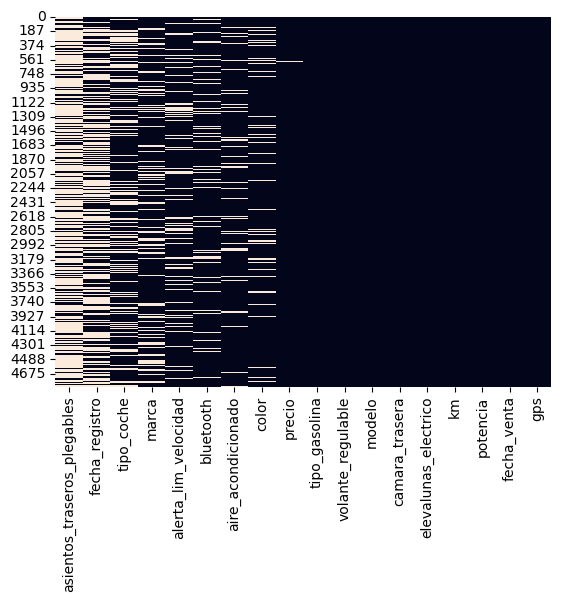

In [11]:
sns.heatmap(df_bmw[col_nulos.index].isnull(), cbar=False)

In [12]:
#Data Binning
bins = np.linspace(min(df_bmw["precio"]), max(df_bmw["precio"]), 4)
group_names = ["Low","Medium","High"]

x= pd.DataFrame(pd.cut(df_bmw["precio"],bins,labels=group_names, include_lowest=True))
x.columns = ["bin"]
#x.hist()
#x.value_counts()
x["precio"] = df_bmw["precio"]
x

,bin,precio
0,Low,11300.0
1,Medium,69700.0
2,Low,10200.0
3,Low,25100.0
4,Low,33400.0
...,...,...
4838,Low,14600.0
4839,Low,17500.0
4840,Low,17000.0
4841,Low,22700.0


/Users/eueunesmo/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


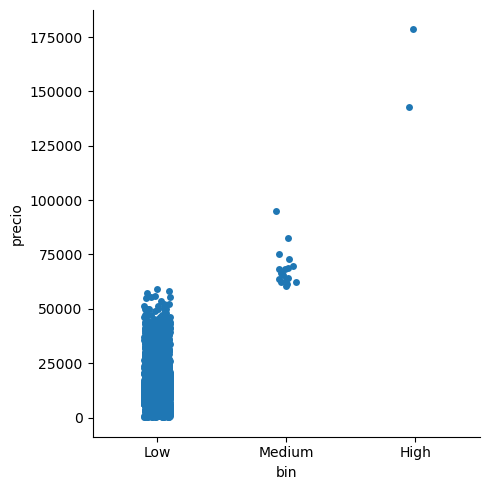

In [13]:
sns.catplot(x,x=x["bin"],y=x["precio"])

In [14]:
n = np.arange(11)
n

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [15]:
from itertools import islice
#Data Binning
nbins=3
step_bins=df_bmw["precio"].shape[0]//nbins
#zeta = list(islice(df_bmw["precio"].sort_values(ascending=True), 1000))
#zeta = np.array_split(df_bmw["precio"].sort_values(ascending=True), step_bins)
#zeta
#x= pd.DataFrame(pd.cut(df_bmw["precio"],bins,labels=group_names, include_lowest=True))
x= pd.DataFrame(pd.cut(df_bmw["precio"].sort_values(ascending=True),2))
x

,precio
2829,"(-78.4, 89300.0]"
1255,"(-78.4, 89300.0]"
4356,"(-78.4, 89300.0]"
565,"(-78.4, 89300.0]"
879,"(-78.4, 89300.0]"
...,...
524,NaN
539,NaN
549,NaN
569,NaN


In [16]:
#df_bmw[df_bmw["tipo_coche","tipo_gasolina"].isnull()].groupby(["modelo","tipo_coche","tipo_gasolina"],dropna=False)["tipo_coche"].value_counts()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

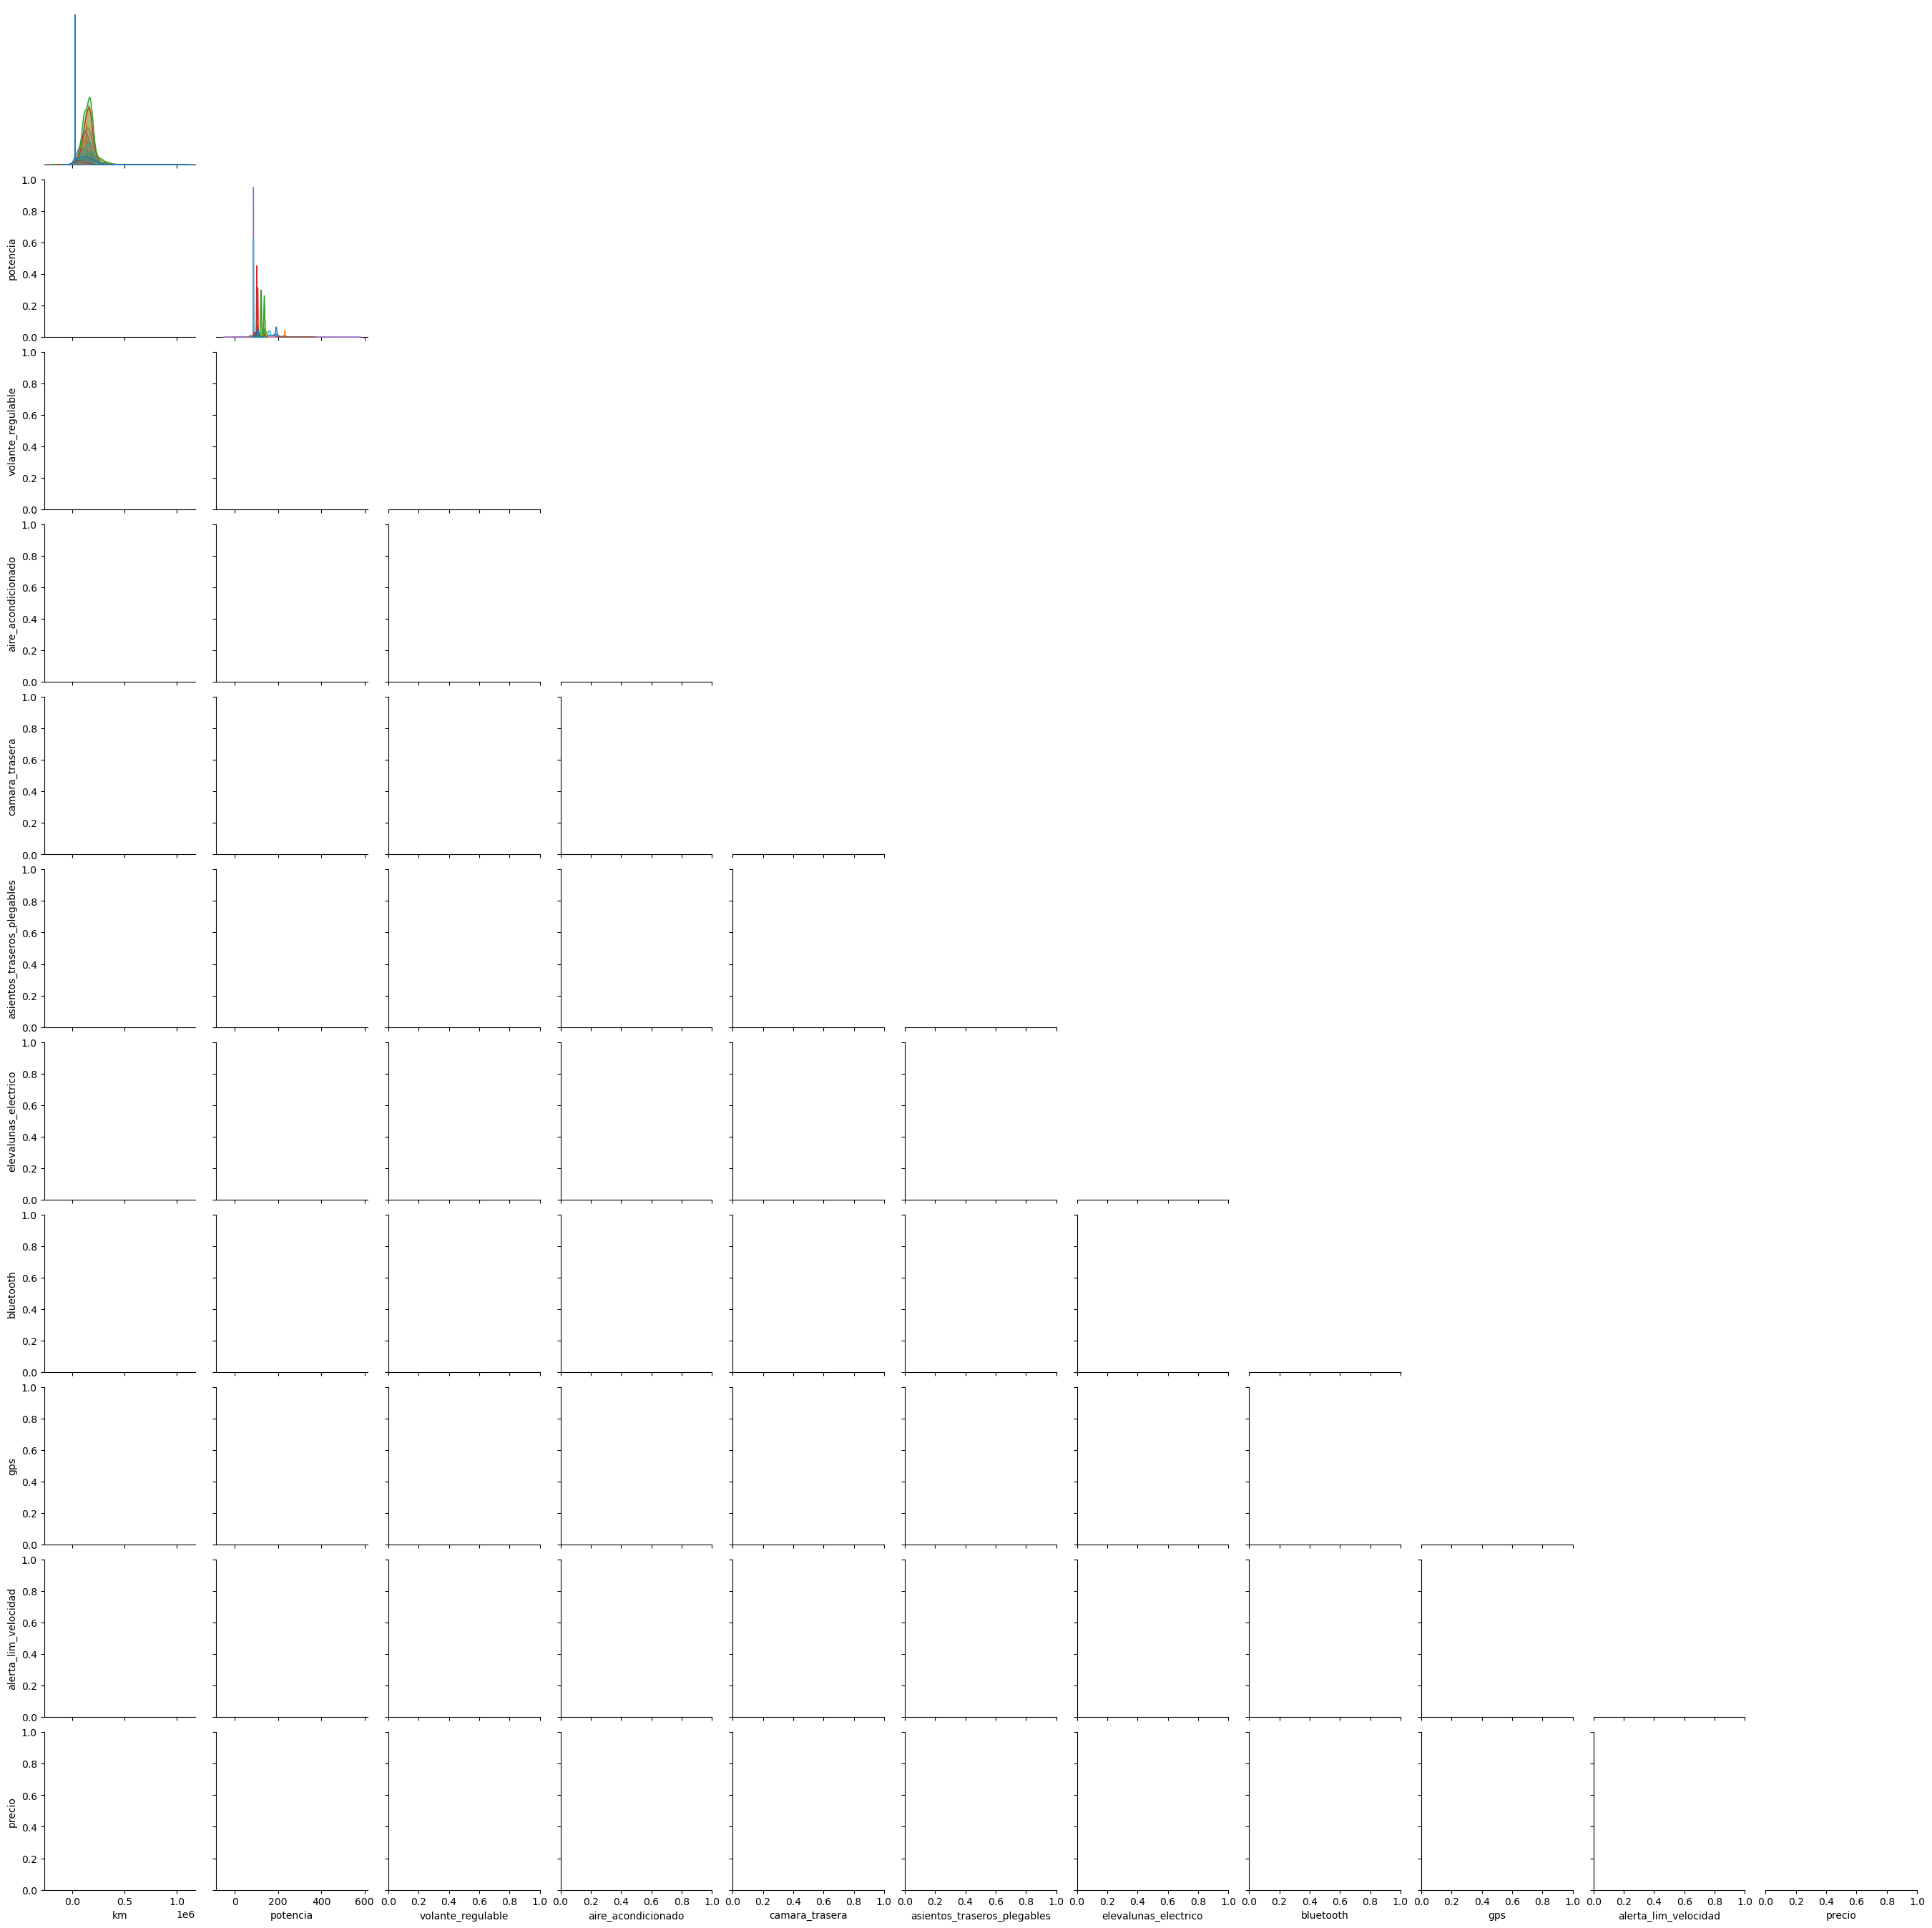

In [17]:
sns.pairplot(df_bmw, 
             hue='modelo', 
             palette="tab10", 
             corner=True)
plt.show()

In [ ]:
df_bmw.describe().loc[['min', 'max']]


,km,potencia,precio
min,-64.0,0.0,100.0
max,1000376.0,423.0,178500.0


In [21]:
list(df_bmw.columns)


['marca',
 'modelo',
 'km',
 'potencia',
 'fecha_registro',
 'tipo_gasolina',
 'color',
 'tipo_coche',
 'volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'asientos_traseros_plegables',
 'elevalunas_electrico',
 'bluetooth',
 'gps',
 'alerta_lim_velocidad',
 'precio',
 'fecha_venta']

In [ ]:
df_bmw.describe().loc[['mean', 'std']].T

,mean,std
km,140959.347862,60208.534313
potencia,128.981826,38.994839
precio,15831.920612,9222.630708


Databinning

In [ ]:
#Categorias por quantidade de elementos
z=pd.DataFrame(df_bmw["precio"].sort_values(ascending=True))
z["binning"] = pd.qcut(df_bmw["precio"].sort_values(ascending=True), 3,labels=["baixo", "medio", "alto"])
z["binning"].hist()
#sns.catplot(z,x=z["binning"],y=z["precio"])






In [ ]:
#Por faixa de elementos
bins = np.linspace(min(df_bmw["precio"]), max(df_bmw["precio"]), 4)
group_names = ["Low","Medium","High"]
x= pd.DataFrame(pd.cut(df_bmw["precio"],bins,labels=group_names, include_lowest=True))
x.columns = ["bin"]
x["precio"] = df_bmw["precio"]
x

Gráficos

In [ ]:
#SNS Pairplot
sns.pairplot(df, 
             hue='label', 
             palette="tab10", 
             corner=True)

plt.show()

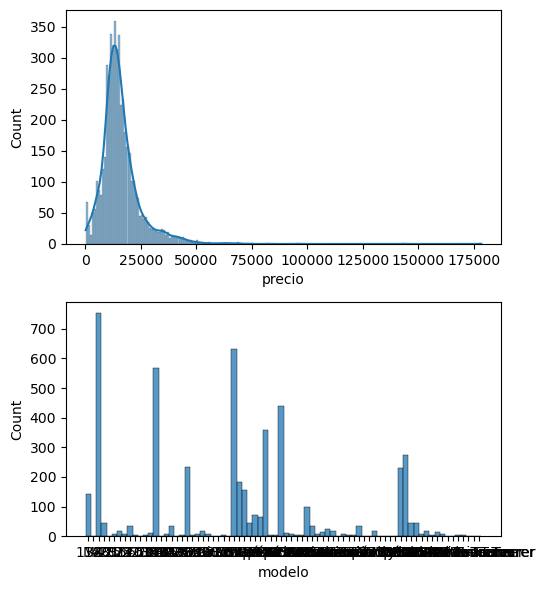

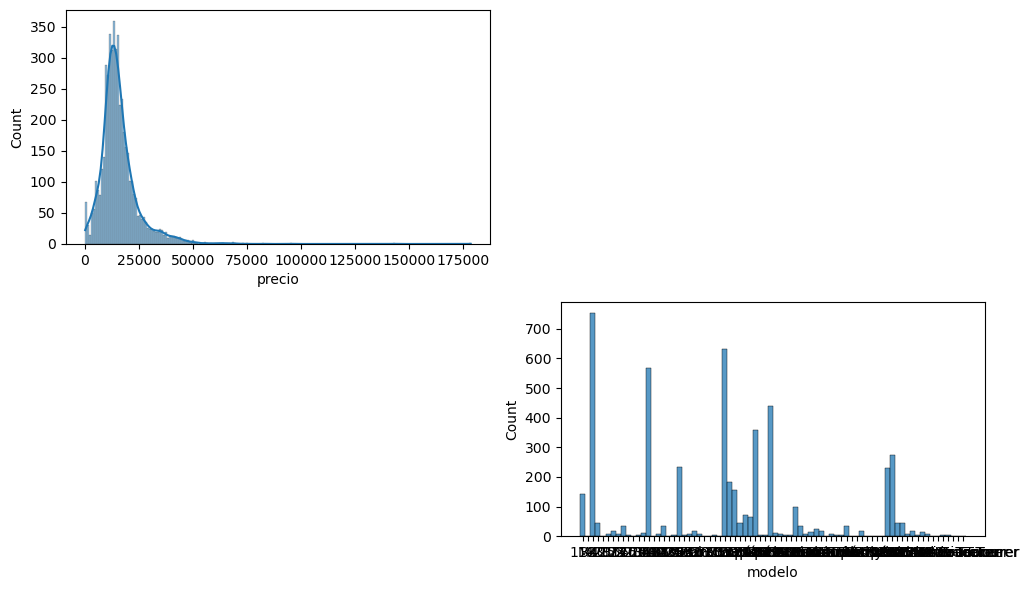

In [ ]:
#multiples gráficos - interessante para automações

i=1 #posição, depende da coluna "3" e da linha "2"
plt.figure(figsize=(15,6))
plt.subplot(2,3,i)
sns.histplot(data=df_bmw, x="precio", kde=True)
plt.subplot(2,3,i+3)
sns.histplot(data=df_bmw, x="modelo")
plt.tight_layout()


Otros

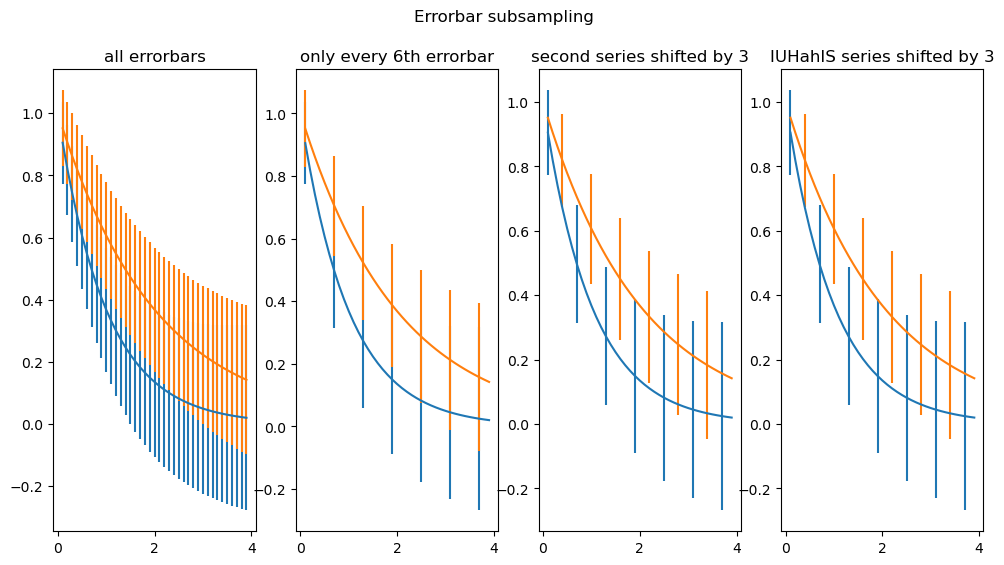

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# example data
x = np.arange(0.1, 4, 0.1)
y1 = np.exp(-1.0 * x)
y2 = np.exp(-0.5 * x)

# example variable error bar values
y1err = 0.1 + 0.1 * np.sqrt(x)
y2err = 0.1 + 0.1 * np.sqrt(x/2)


fig, (ax0, ax1, ax2,bx1) = plt.subplots(nrows=1, ncols=4, sharex=True,
                                    figsize=(12, 6))

ax0.set_title('all errorbars')
ax0.errorbar(x, y1, yerr=y1err)
ax0.errorbar(x, y2, yerr=y2err)

ax1.set_title('only every 6th errorbar')
ax1.errorbar(x, y1, yerr=y1err, errorevery=6)
ax1.errorbar(x, y2, yerr=y2err, errorevery=6)

ax2.set_title('second series shifted by 3')
ax2.errorbar(x, y1, yerr=y1err, errorevery=(0, 6))
ax2.errorbar(x, y2, yerr=y2err, errorevery=(3, 6))

bx1.set_title('IUHahIS series shifted by 3')
bx1.errorbar(x, y1, yerr=y1err, errorevery=(0, 6))
bx1.errorbar(x, y2, yerr=y2err, errorevery=(3, 6))

fig.suptitle('Errorbar subsampling')
plt.show()

In [ ]:
#recuento de elementos enteros o convertibles para ennteros
np.bincount(df_bmw["asientos_traseros_plegables"].dropna())


array([1150,  302])

In [37]:
df_bmw["precio"].quantile(0.25)

10800.0

<Axes: xlabel='precio'>

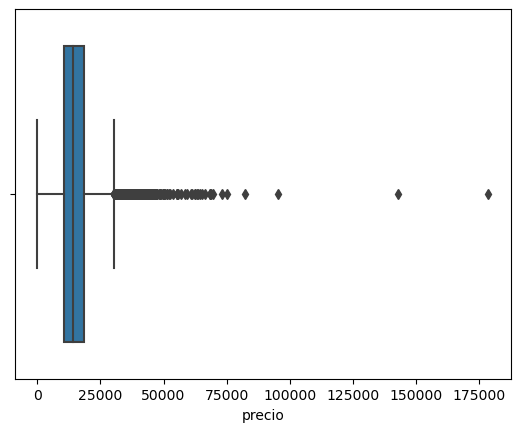

In [35]:
sns.boxplot(df_bmw, x="precio")

In [66]:
# Identificando valores nulos
df_bmw.isnull().any()

# Criando dicionários para adicioinar os valores
dict_outliers_zscore = {}
dict_outliers_iqr = {}
dict_outliers_percentile = {}

# Definindo uma função para coleta de outliers por meio do método Z-score com maior robustez
def z_r_score_outlier(data):
    outliers = []
    med = np.median(data)
    ma = stats.median_abs_deviation(data)
    for i in data: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            outliers.append(i)      
    return outliers

# Definindo uma função para coleta de outliers por meio do método IQR
def iqr_outliers(data):
    outliers = []
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 2.5 * iqr
    Upper_tail = q3 + 2.5 * iqr
    for i in data:
        if i > Upper_tail or i < Lower_tail:
            outliers.append(i)
    return outliers

# Definindo uma função para coleta de outliers por meio da análise do percentil
def winsorization_outliers(data):
    outliers = []
    q1 = np.percentile(data, 1)
    q3 = np.percentile(data, 99)
    for i in data:
        if i > q3 or i < q1:
            outliers.append(i)
    return outliers
    
# Coletando os outliers
for i in df_bmw.columns:
    if df_bmw[i].dtype == "float64":
        df_order=df_bmw[i].sort_values(ascending=True)
        outliers_zscore = z_r_score_outlier(df_order)
        if len(outliers_zscore) > 0:
            dict_outliers_zscore[i] = outliers_zscore
        outliers_iqr = iqr_outliers(df_order)
        if len(outliers_iqr) > 0:
            dict_outliers_iqr[i] = outliers_iqr
        outliers_percentile = winsorization_outliers(df_order)
        if len(outliers_percentile) > 0:
            dict_outliers_percentile[i] = outliers_percentile
            
# Observando os outliers
print("WINSOR")
for i in dict_outliers_percentile.items():
    print(i)

# Observando os outliers
print("IQR")
for i in dict_outliers_iqr.items():
    print(i)


# Observando os outliers
print("ZEND")
for i in dict_outliers_zscore.items():
    print(i)


#df_numerical = df.select_dtypes(include = ['int','float'])


WINSOR
IQR
('km', [358332.0, 358333.0, 359648.0, 359661.0, 362024.0, 362902.0, 364547.0, 365262.0, 365452.0, 365584.0, 366026.0, 367523.0, 370014.0, 370256.0, 375686.0, 377156.0, 378915.0, 384170.0, 384698.0, 388616.0, 391309.0, 394135.0, 398043.0, 400654.0, 405816.0, 439060.0, 477571.0, 484615.0, 1000376.0])
('potencia', [0.0, 224.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0, 230.0

/var/folders/pf/jmy6c5mn6nq33vg6h8hlpmdw0000gn/T/ipykernel_996/2191805034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/pf/jmy6c5mn6nq33vg6h8hlpmdw0000gn/T/ipykernel_996/2191805034.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


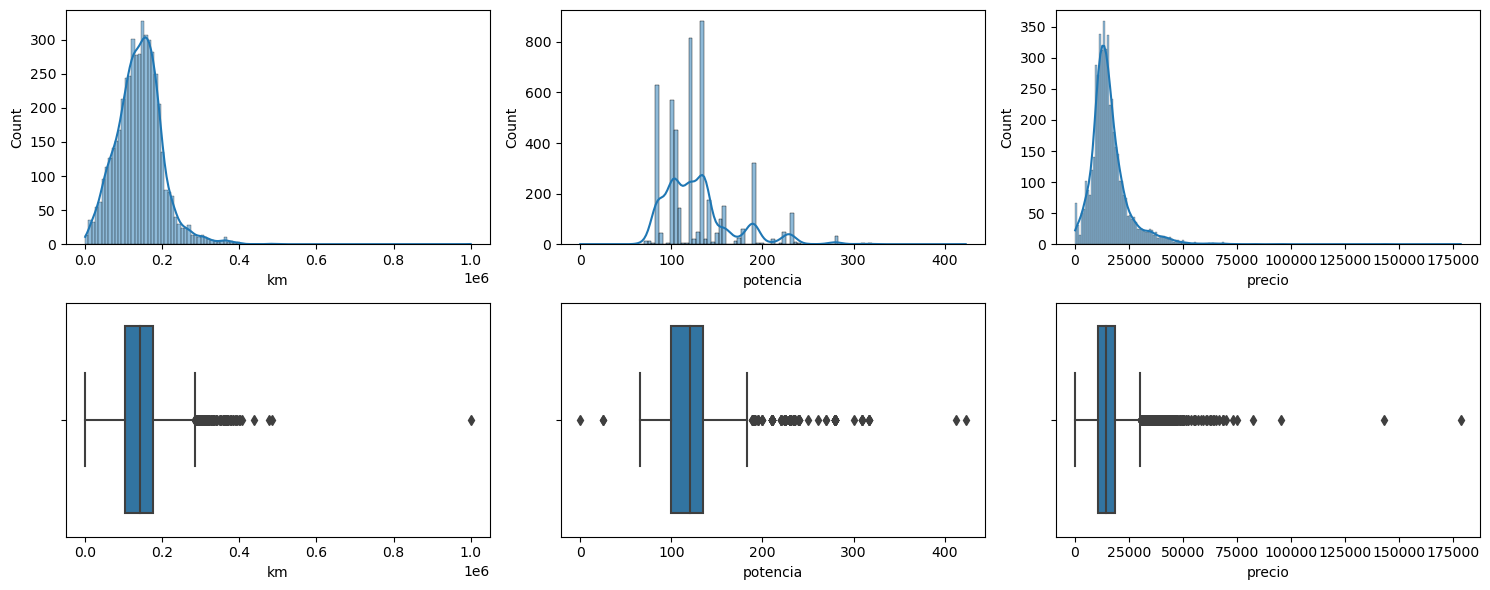

In [74]:
x=1
plt.figure(figsize=(15,6))
for i in df_bmw.columns:
    if df_bmw[i].dtype == "float64":
        plt.subplot(2,3,x)
        sns.histplot(data=df_bmw, x=i, kde=True)
        plt.subplot(2,3,x+3)
        sns.boxplot(data=df_bmw, x=i)
        plt.tight_layout()
        x+=1

In [71]:
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         